In [176]:
import pandas as pd
import numpy as np


import seaborn as sns
import matplotlib.pyplot as plt


from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
from nltk.stem.wordnet import WordNetLemmatizer
import nltk
nltk.download('wordnet')
from nltk.stem import PorterStemmer


from sklearn.model_selection import train_test_split

import os
from wordcloud import WordCloud
from PIL import Image

from sklearn.utils import resample


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


#https://github.com/briannalytle/reddit_nlp/blob/master/EDA.ipynb


[nltk_data] Downloading package stopwords to C:\Users\Alberto
[nltk_data]     Vilas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Alberto
[nltk_data]     Vilas\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [131]:
df = pd.read_csv("reddit_hot_submissions.csv")
print(df.head(2))

                                               title          time  \
0  AOC Says U.S. 'Must Atone' for Rights Violatio...  1.600175e+09   
1  The Mandalorian | Season 2 Official Trailer | ...  1.600178e+09   

  description  num_comments  num_upvotes  upvote_ratio link_flair   nsfw  \
0         NaN           655        14641          0.95        NaN  False   
1         NaN          1122         9638          0.97         TV  False   

                                     subreddit_title          redditor  \
0                                           Politics  MatrixCapitalism   
1  Star Wars - A long time ago, in a galaxy far, ...         raynehk14   

                                                 url  
0  https://www.newsweek.com/aoc-us-must-atone-rig...  
1        https://www.youtube.com/watch?v=eW7Twd85m2g  


Convert target to binary

In [132]:
df['nsfw'] = [1 if n==True else 0 for n in df.nsfw]

In [133]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   title            1000 non-null   object 
 1   time             1000 non-null   float64
 2   description      58 non-null     object 
 3   num_comments     1000 non-null   int64  
 4   num_upvotes      1000 non-null   int64  
 5   upvote_ratio     1000 non-null   float64
 6   link_flair       415 non-null    object 
 7   nsfw             1000 non-null   int64  
 8   subreddit_title  1000 non-null   object 
 9   redditor         1000 non-null   object 
 10  url              1000 non-null   object 
dtypes: float64(2), int64(3), object(6)
memory usage: 86.1+ KB


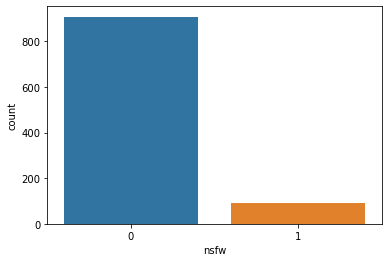

In [134]:
sns.countplot(x='nsfw', data=df)

Replace NaN with ' ', because it's necessary for df.title + df.description

Because tittle + description is a better field 


In [135]:
df['description']=df['description'].replace(np.nan, " ")
df['all_text'] = df['title'] + df['description']
df.head()

,title,time,description,num_comments,num_upvotes,upvote_ratio,link_flair,nsfw,subreddit_title,redditor,url,all_text
0,AOC Says U.S. 'Must Atone' for Rights Violatio...,1.600175e+09,,655,14641,0.95,NaN,0,Politics,MatrixCapitalism,https://www.newsweek.com/aoc-us-must-atone-rig...,AOC Says U.S. 'Must Atone' for Rights Violatio...
1,The Mandalorian | Season 2 Official Trailer | ...,1.600178e+09,,1122,9638,0.97,TV,0,"Star Wars - A long time ago, in a galaxy far, ...",raynehk14,https://www.youtube.com/watch?v=eW7Twd85m2g,The Mandalorian | Season 2 Official Trailer | ...
2,Russian opposition leader Alexei Navalny share...,1.600170e+09,,1427,53426,0.96,NaN,0,Reddit Pics,unknown_human,https://i.redd.it/75deaqxztan51.jpg,Russian opposition leader Alexei Navalny share...
3,The Big True,1.600171e+09,,308,27384,0.97,NaN,0,People Person's Paper People,SpongeNoob24,https://v.redd.it/pipkbc6ywan51,The Big True
4,"TIL Ray Burton, who was the father of Cliff Bu...",1.600169e+09,,954,39959,0.94,NaN,0,Today I Learned (TIL),phantom416,https://loudwire.com/cliff-burton-father-donat...,"TIL Ray Burton, who was the father of Cliff Bu..."


In [136]:
df.groupby(['nsfw']).describe()

time                                                          \
      count          mean           std           min           25%   
nsfw                                                                  
0     908.0  1.600160e+09  13693.900563  1.600118e+09  1.600151e+09   
1      92.0  1.600161e+09  12416.817225  1.600129e+09  1.600158e+09   

                                               num_comments              ...  \
               50%           75%           max        count        mean  ...   
nsfw                                                                     ...   
0     1.600164e+09  1.600171e+09  1.600183e+09        908.0  236.007709  ...   
1     1.600166e+09  1.600170e+09  1.600182e+09         92.0   54.804348  ...   

     num_upvotes           upvote_ratio                                        \
             75%       max        count      mean       std   min   25%   50%   
nsfw                                                                            
0        7399.50  100033.0        908.0  0.965374  0.033502  0.65  0.96  0.98   
1        2927.75   27960.0         92.0  0.970870  0.018907  0.88  0.97  0.98   

                  
       75%   max  
nsfw              
0     0.98  1.00  
1     0.98  0.99  

[2 rows x 32 columns]

# Clean Data


In [137]:
#Remove punctuacion and special characters based on pattern using RegEx

#remove punctuation and special characters
tokenizer = RegexpTokenizer(r'\w+')


df['all_text'] = df['all_text'].apply(lambda  x: tokenizer.tokenize(x.lower()))

df["all_text"].head()

0    [aoc, says, u, s, must, atone, for, rights, vi...
1    [the, mandalorian, season, 2, official, traile...
2    [russian, opposition, leader, alexei, navalny,...
3                                     [the, big, true]
4    [til, ray, burton, who, was, the, father, of, ...
Name: all_text, dtype: object

# Remove Stop Words


In [138]:
def remove_stopwords(text):
    words = [w for w in text if w not in stopwords.words('english')]
    return words

In [139]:
#experimentarei com stop words e posteriormente tentarei sem, porque poderão os textos ficarem muito curtos

In [140]:
df['all_text'] = df['all_text'].apply(lambda  x: remove_stopwords(x))

# Stemming & Lemmatizing

In [141]:
lemmatizer = WordNetLemmatizer()

def word_lemmatizer(text):
    lem = " ".join([lemmatizer.lemmatize(i) for i in text])
    return lem

stemmer = PorterStemmer()

def word_stemmer(text):
    stem = " ".join([stemmer.stem(i) for i in text])
    return stem

In [142]:
df['all_text_l'] = df['all_text'].apply(lambda  x: word_lemmatizer(x))
df['all_text_s'] = df['all_text'].apply(lambda  x: word_stemmer(x))

print(df['all_text_s'])

0      aoc say u must aton right violat whistleblow i...
1             mandalorian season 2 offici trailer disney
2      russian opposit leader alexei navalni share fi...
3                                               big true
4      til ray burton father cliff burton use cliff r...
                             ...                        
995                                          dad sometim
996    behold made friend mine made wall friend new a...
997                                           anti cheat
998                                           wanna join
999    arm co founder start save arm campaign keep in...
Name: all_text_s, Length: 1000, dtype: object


# Word Cloud Visualization

In [143]:
df_sfw = df[df.nsfw==0]
df_nsfw = df[df.nsfw==1]

def create_word_cloud(df):
    """
        Word cloud requires input of string
    """
    df_list = df['all_text_l'].tolist()
    df_string = ("").join(df_list)
    
    wordcloud = WordCloud(max_font_size = 50, max_words=50, margin=0, background_color = "white", colormap="Reds").generate(df_string)

    plt.figure()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.margins(x=0, y=0)
    plt.show()
    


Word Cloud - nsfw

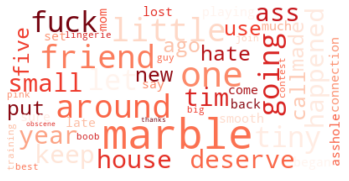

In [144]:
create_word_cloud(df_nsfw)

Word Cloud - sfw

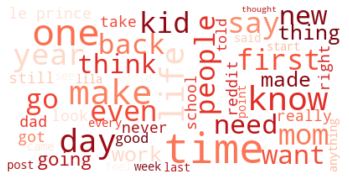

In [145]:
create_word_cloud(df_sfw)

# Handle imbalanced datasets

In [169]:
df["nsfw"].value_counts()

0    908
1     92
Name: nsfw, dtype: int64

In [170]:
# Down-sample Majority Class

df_sfw_downsampled = resample(df_sfw, 
                                 replace=False,    # sample without replacement
                                 n_samples=92,     # to match minority class
                                 random_state=0)

df_downsampled = pd.concat([df_sfw_downsampled, df_nsfw])
df_downsampled.nsfw.value_counts()

1    92
0    92
Name: nsfw, dtype: int64

# Split train and test data

In [171]:
#define target var
y=df_downsampled['nsfw']

X_train, X_test, y_train, y_test = train_test_split(df_downsampled['all_text_l'], y, test_size=0.2, random_state=0)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(147,) (147,)
(37,) (37,)


# Tf-IDF Vectorizer

In [172]:
#Naives bayes requires Tf-IDF vectors

x_lst = X_train.tolist()
y_lst = y_test.tolist()
vectorizer = TfidfVectorizer()
vetor_train_transformed = vectorizer.fit_transform(x_lst) #gives tf idf vector for x_train
vetor_test_transformed  = vectorizer.transform(X_test) #gives tf idf vector for x_test

# Fit/Train Model

In [173]:
model = MultinomialNB()
model.fit(vetor_train_transformed, y_train)

MultinomialNB()

In [174]:
pred = model.predict(vetor_test_transformed)

In [177]:
matrix = confusion_matrix(y_lst, pred)
print('Confusion Matrix :')
print(matrix)
print ('Accuracy Score :',accuracy_score(y_lst, pred))
print ('Report : ')
print (classification_report(y_lst, pred) )
score_2 = f1_score(y_lst, pred, average = 'binary')
print('F-Measure: %.3f' % score_2)

Confusion Matrix :
[[13  2]
 [ 9 13]]
Accuracy Score : 0.7027027027027027
Report : 
              precision    recall  f1-score   support

           0       0.59      0.87      0.70        15
           1       0.87      0.59      0.70        22

    accuracy                           0.70        37
   macro avg       0.73      0.73      0.70        37
weighted avg       0.75      0.70      0.70        37

F-Measure: 0.703
